In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [4]:
import h5py
import numpy as np
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

In [5]:
arrays = {}
f = h5py.File('MNIST_Autocorrelation.mat')

In [6]:
print(list(f.keys()))

for k, v in f.items():
    arrays[k] = np.array(v)

['TestData', 'TestLabels', 'TrainData', 'TrainLabels']


In [23]:
X_train = arrays['TrainData']
y_train = arrays['TrainLabels'].squeeze()
X_test = arrays['TestData']
y_test = arrays['TestLabels'].squeeze()

NUM_CLASSES = 10
NUM_TRAIN_IMAGES = 10000

In [24]:
# https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html
#X_train = X_train[:,:,0:NUM_TRAIN_IMAGES]
X_train = X_train.transpose(2, 0, 1)
X_train = X_train/255.0 - 0.5
img_wh = 56;
# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
print(X_train.shape)

(60000, 56, 56, 1)


In [25]:
# https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html
X_test = X_test.transpose(2, 0, 1)
X_test = X_test/255.0 - 0.5
img_wh = 56;
# NEW: Let's start by fixing the sizes
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
print(X_test.shape)

(10000, 56, 56, 1)


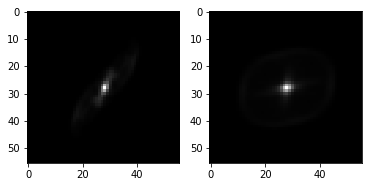

In [10]:
plt.subplot(1,2,1)
plt.imshow(X_train[10].squeeze(),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[10].squeeze(),cmap='gray')
plt.show()

In [26]:
# and one hot encoding the output values
#y_train = y_train[0:NUM_TRAIN_IMAGES]

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(60000, 10)
(10000, 10)


In [27]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])


cnn.fit(X_train, y_train_ohe, 
        batch_size=256, epochs=20, 
        shuffle=True, verbose=1)


Epoch 1/20
60000/60000 [==============================] - 512s 9ms/step - loss: 1.7410 - acc: 0.3787
Epoch 2/20
60000/60000 [==============================] - 502s 8ms/step - loss: 1.1340 - acc: 0.5963
Epoch 3/20
60000/60000 [==============================] - 496s 8ms/step - loss: 1.0057 - acc: 0.6567
Epoch 4/20
60000/60000 [==============================] - 500s 8ms/step - loss: 0.8825 - acc: 0.6959
Epoch 5/20
60000/60000 [==============================] - 496s 8ms/step - loss: 0.8215 - acc: 0.7201
Epoch 6/20
60000/60000 [==============================] - 496s 8ms/step - loss: 0.7725 - acc: 0.7347
Epoch 7/20
60000/60000 [==============================] - 497s 8ms/step - loss: 0.7312 - acc: 0.7538
Epoch 8/20
60000/60000 [==============================] - 494s 8ms/step - loss: 0.6953 - acc: 0.7654
Epoch 9/20
60000/60000 [==============================] - 490s 8ms/step - loss: 0.6554 - acc: 0.7805
Epoch 10/20
60000/60000 [==============================] - 497s 8ms/step - loss: 0.6273 - a

In [28]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

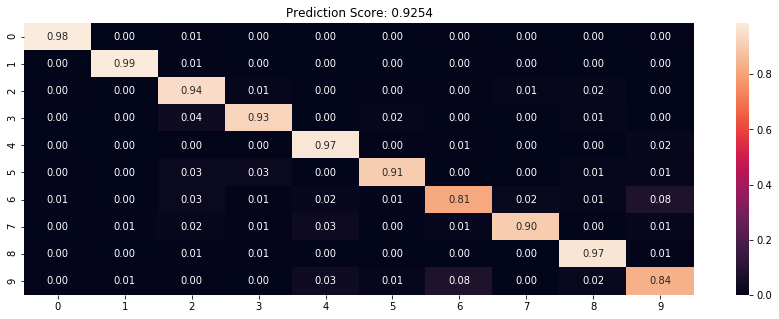

In [29]:
summarize_net(cnn, X_test, y_test, title_text='Prediction Score: ')